In [121]:
from tqdm import tqdm
import pickle as pkl
import numpy as np
import pandas as pd
import json
import os
import scipy
import random

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import copy

In [122]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [123]:
sigma_int = pd.read_csv('Data/sigma_i.csv', header=None).values.T
sigma_bdry = pd.read_csv('Data/sigma_b.csv', header=None).values.T
sigma_int_grad = pd.read_csv('Data/sigma_i_grad.csv', header=None).values

u_int = pd.read_csv('Data/potential_i.csv', header=None).values.T
u_bdry = pd.read_csv('Data/potential_b.csv', header=None).values.T

x_int = pd.read_csv('Data/pts_i.csv', header=None).values.T
x_bdry = pd.read_csv('Data/pts_b.csv', header=None).values.T

In [124]:
u_int.shape, sigma_int.shape, sigma_int_grad.shape, x_int.shape,\
u_bdry.shape, sigma_bdry.shape, x_bdry.shape

((3000, 1), (3000, 1), (3000, 2), (3000, 2), (300, 1), (300, 1), (300, 2))

In [125]:
s_int = torch.FloatTensor(sigma_int).to(device)
s_int_grad = torch.FloatTensor(sigma_int_grad).to(device)
s_bdry = torch.FloatTensor(sigma_bdry).to(device)

u_int = torch.FloatTensor(u_int).to(device)
u_bdry = torch.FloatTensor(u_bdry).to(device)

x_int = torch.FloatTensor(x_int).to(device).requires_grad_(True)
x_bdry = torch.FloatTensor(x_bdry).to(device)

In [126]:
output_s_x, output_s_y = s_int_grad[:,0].view(-1,1), s_int_grad[:,1].view(-1,1)

In [127]:
output_s_x

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [128]:
output_s_y

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [129]:
Nx = 100
Ny = 100
xmax = 1
ymax = 1
topk = 40

x = torch.linspace(-xmax, xmax, Nx)
y = torch.linspace(-ymax, ymax, Ny)

xy = torch.meshgrid(x,y)
xy_plot = torch.cat([xy[0].reshape(-1,1), xy[1].reshape(-1,1)],dim=1).to(device)

In [130]:
class model(nn.Module):
    def __init__(self, hidden_dims):
        super(model, self).__init__()

        self.layers = []
        for i in range(len(hidden_dims)-1):
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.layers = nn.ModuleList(self.layers)

        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight)

        self.act = nn.Tanh()

    def forward(self, x):
        x = self.act(self.layers[0](x))
        for layer in self.layers[1:-1]:
            x = self.act(layer(x))
        x = self.layers[-1](x)
        return x
    
    def get_weights(self):
        weights = torch.cat([layer.weight.view(-1) for layer in self.layers])
        return weights

In [131]:
def calculate_derivative(y, x):
    return torch.autograd.grad(y, x, create_graph=True, grad_outputs=torch.ones(y.size()).to(device))[0]

def train(u_model, optimizer, loss_f):

    u_model.train()
    #s_model.train()
    optimizer.zero_grad()

    output_u = u_model(x_int)
    output_u_bdry = u_model(x_bdry)
    #output_s = s_model(x_int)
    #output_s_bdry = s_model(x_bdry)

    output_grad_u = calculate_derivative(output_u, x_int)
    #output_grad_s = calculate_derivative(output_s, x_int)

    #output_s_x, output_s_y = output_grad_s[:,0].view(-1,1), output_grad_s[:,1].view(-1,1)
    #output_s_x, output_s_y = s_int_grad[:,0].view(-1,1), s_int_grad[:,1].view(-1,1)
    output_u_x, output_u_y = output_grad_u[:,0].view(-1,1), output_grad_u[:,1].view(-1,1)
    output_u_xx, output_u_yy = calculate_derivative(output_u_x, x_int)[:,0].view(-1,1), calculate_derivative(output_u_y, x_int)[:,1].view(-1,1)

    ge = output_s_x*output_u_x + output_s_y*output_u_y + s_int*(output_u_xx + output_u_yy)
    loss_l2 = loss_f(ge, torch.zeros_like(output_u))
    loss_inf = torch.topk(torch.abs(ge).view(-1), topk).values.mean()
    loss_bdry = loss_f(output_u_bdry, u_bdry)# + loss_f(output_s, s_int) + loss_f(output_s_bdry, s_bdry)
    regularizer = torch.norm(u_model.get_weights())

    lamb = 0.01
    mu = 0.01
    eta = 1e-8
    loss = lamb * loss_l2 + mu * loss_inf + loss_bdry + eta * regularizer
    loss.backward()
    optimizer.step()

    return loss_l2.item(), loss_inf.item(), loss_bdry.item()

In [132]:
def plot(u_model) :
    u_model.eval()

    figure = plt.figure(figsize=(5,5))
    ax = figure.add_subplot(1,1,1)
    output_u = (u_model(xy_plot) * (xy_plot.norm(dim=1)<=1).float().view(-1,1)).cpu().detach()
    plt.pcolor(output_u.view(Nx, Ny).T)
    ax.set_title('u prediction')
    plt.colorbar()

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 1/20000 [00:00<1:14:12,  4.49it/s]

0/20000 | loss_l2: 31791.156250 |  loss_inf: 1155.643433 | loss_bdry: 0.048284 | test_err: 0.042764


  1%|          | 110/20000 [00:02<05:13, 63.46it/s]

100/20000 | loss_l2: 67.136597 |  loss_inf: 55.576965 | loss_bdry: 0.094108 | test_err: 0.064795


  1%|          | 211/20000 [00:03<05:04, 64.96it/s]

200/20000 | loss_l2: 33.932911 |  loss_inf: 38.559761 | loss_bdry: 0.096149 | test_err: 0.065822


  2%|▏         | 313/20000 [00:05<05:41, 57.68it/s]

300/20000 | loss_l2: 20.553383 |  loss_inf: 29.382578 | loss_bdry: 0.089343 | test_err: 0.058904


  2%|▏         | 408/20000 [00:06<05:28, 59.61it/s]

400/20000 | loss_l2: 14.950746 |  loss_inf: 24.334690 | loss_bdry: 0.082401 | test_err: 0.051987


  3%|▎         | 514/20000 [00:08<05:02, 64.36it/s]

500/20000 | loss_l2: 12.168622 |  loss_inf: 21.737825 | loss_bdry: 0.076334 | test_err: 0.046198


  3%|▎         | 614/20000 [00:10<05:15, 61.40it/s]

600/20000 | loss_l2: 10.041972 |  loss_inf: 19.547804 | loss_bdry: 0.070616 | test_err: 0.040807


  4%|▎         | 710/20000 [00:11<04:44, 67.91it/s]

700/20000 | loss_l2: 8.129276 |  loss_inf: 17.566639 | loss_bdry: 0.065875 | test_err: 0.036497


  4%|▍         | 810/20000 [00:13<04:51, 65.85it/s]

800/20000 | loss_l2: 6.490865 |  loss_inf: 15.643521 | loss_bdry: 0.061752 | test_err: 0.032789


  5%|▍         | 908/20000 [00:14<04:51, 65.53it/s]

900/20000 | loss_l2: 5.135899 |  loss_inf: 13.834781 | loss_bdry: 0.058508 | test_err: 0.029901


  5%|▌         | 1007/20000 [00:16<06:18, 50.14it/s]

1000/20000 | loss_l2: 4.063509 |  loss_inf: 12.408668 | loss_bdry: 0.055790 | test_err: 0.027668


  6%|▌         | 1113/20000 [00:18<05:03, 62.22it/s]

1100/20000 | loss_l2: 3.199652 |  loss_inf: 11.134374 | loss_bdry: 0.053556 | test_err: 0.025947


  6%|▌         | 1212/20000 [00:19<05:04, 61.70it/s]

1200/20000 | loss_l2: 2.495257 |  loss_inf: 9.986339 | loss_bdry: 0.051899 | test_err: 0.024778


  7%|▋         | 1312/20000 [00:21<04:46, 65.15it/s]

1300/20000 | loss_l2: 1.945884 |  loss_inf: 8.899642 | loss_bdry: 0.050647 | test_err: 0.023999


  7%|▋         | 1414/20000 [00:22<04:28, 69.33it/s]

1400/20000 | loss_l2: 1.521414 |  loss_inf: 8.016101 | loss_bdry: 0.049790 | test_err: 0.023557


  8%|▊         | 1513/20000 [00:24<04:30, 68.33it/s]

1500/20000 | loss_l2: 1.232414 |  loss_inf: 7.359529 | loss_bdry: 0.049207 | test_err: 0.023328


  8%|▊         | 1608/20000 [00:25<04:34, 67.07it/s]

1600/20000 | loss_l2: 1.029746 |  loss_inf: 6.761398 | loss_bdry: 0.048816 | test_err: 0.023263


  9%|▊         | 1715/20000 [00:27<04:35, 66.42it/s]

1700/20000 | loss_l2: 0.882288 |  loss_inf: 6.260753 | loss_bdry: 0.048552 | test_err: 0.023277


  9%|▉         | 1815/20000 [00:28<04:27, 67.98it/s]

1800/20000 | loss_l2: 0.785149 |  loss_inf: 5.871310 | loss_bdry: 0.048404 | test_err: 0.023351


 10%|▉         | 1907/20000 [00:30<05:17, 57.05it/s]

1900/20000 | loss_l2: 0.716069 |  loss_inf: 5.571124 | loss_bdry: 0.048295 | test_err: 0.023499


 10%|█         | 2006/20000 [00:32<06:37, 45.22it/s]

2000/20000 | loss_l2: 0.663369 |  loss_inf: 5.355597 | loss_bdry: 0.048215 | test_err: 0.023645


 11%|█         | 2107/20000 [00:33<04:21, 68.30it/s]

2100/20000 | loss_l2: 0.619910 |  loss_inf: 5.153970 | loss_bdry: 0.048178 | test_err: 0.023793


 11%|█         | 2210/20000 [00:35<04:18, 68.71it/s]

2200/20000 | loss_l2: 0.578221 |  loss_inf: 4.955373 | loss_bdry: 0.048196 | test_err: 0.023967


 12%|█▏        | 2312/20000 [00:36<04:28, 65.78it/s]

2300/20000 | loss_l2: 0.536232 |  loss_inf: 4.752601 | loss_bdry: 0.048227 | test_err: 0.024133


 12%|█▏        | 2410/20000 [00:38<05:22, 54.57it/s]

2400/20000 | loss_l2: 0.495908 |  loss_inf: 4.563633 | loss_bdry: 0.048288 | test_err: 0.024294


 13%|█▎        | 2509/20000 [00:39<04:35, 63.60it/s]

2500/20000 | loss_l2: 0.459878 |  loss_inf: 4.392804 | loss_bdry: 0.048322 | test_err: 0.024420


 13%|█▎        | 2614/20000 [00:41<04:21, 66.40it/s]

2600/20000 | loss_l2: 0.421974 |  loss_inf: 4.192763 | loss_bdry: 0.048352 | test_err: 0.024510


 14%|█▎        | 2708/20000 [00:43<04:27, 64.63it/s]

2700/20000 | loss_l2: 0.387737 |  loss_inf: 4.028221 | loss_bdry: 0.048425 | test_err: 0.024634


 14%|█▍        | 2809/20000 [00:44<04:26, 64.60it/s]

2800/20000 | loss_l2: 0.351567 |  loss_inf: 3.827109 | loss_bdry: 0.048462 | test_err: 0.024695


 15%|█▍        | 2908/20000 [00:46<04:37, 61.62it/s]

2900/20000 | loss_l2: 0.316096 |  loss_inf: 3.608990 | loss_bdry: 0.048504 | test_err: 0.024745


 15%|█▌        | 3007/20000 [00:47<05:48, 48.77it/s]

3000/20000 | loss_l2: 0.283047 |  loss_inf: 3.398577 | loss_bdry: 0.048546 | test_err: 0.024810


 16%|█▌        | 3108/20000 [00:49<04:19, 65.00it/s]

3100/20000 | loss_l2: 0.254766 |  loss_inf: 3.234744 | loss_bdry: 0.048571 | test_err: 0.024841


 16%|█▌        | 3209/20000 [00:50<04:22, 63.92it/s]

3200/20000 | loss_l2: 0.222895 |  loss_inf: 3.017977 | loss_bdry: 0.048625 | test_err: 0.024873


 17%|█▋        | 3309/20000 [00:52<04:35, 60.53it/s]

3300/20000 | loss_l2: 0.195994 |  loss_inf: 2.809488 | loss_bdry: 0.048635 | test_err: 0.024869


 17%|█▋        | 3413/20000 [00:54<04:12, 65.64it/s]

3400/20000 | loss_l2: 0.173254 |  loss_inf: 2.665501 | loss_bdry: 0.048653 | test_err: 0.024861


 18%|█▊        | 3507/20000 [00:55<04:05, 67.29it/s]

3500/20000 | loss_l2: 0.147014 |  loss_inf: 2.452611 | loss_bdry: 0.048706 | test_err: 0.024846


 18%|█▊        | 3609/20000 [00:57<04:02, 67.70it/s]

3600/20000 | loss_l2: 0.125760 |  loss_inf: 2.241228 | loss_bdry: 0.048704 | test_err: 0.024829


 19%|█▊        | 3711/20000 [00:58<03:55, 69.25it/s]

3700/20000 | loss_l2: 0.111733 |  loss_inf: 2.129003 | loss_bdry: 0.048755 | test_err: 0.024789


 19%|█▉        | 3812/20000 [01:00<04:21, 61.85it/s]

3800/20000 | loss_l2: 0.092485 |  loss_inf: 1.929583 | loss_bdry: 0.048755 | test_err: 0.024758


 20%|█▉        | 3912/20000 [01:01<04:13, 63.44it/s]

3900/20000 | loss_l2: 0.083585 |  loss_inf: 1.851415 | loss_bdry: 0.048772 | test_err: 0.024692


 20%|██        | 4003/20000 [01:03<05:46, 46.21it/s]

4000/20000 | loss_l2: 0.068638 |  loss_inf: 1.671252 | loss_bdry: 0.048799 | test_err: 0.024676


 21%|██        | 4108/20000 [01:05<03:59, 66.41it/s]

4100/20000 | loss_l2: 0.061105 |  loss_inf: 1.585138 | loss_bdry: 0.048819 | test_err: 0.024648


 21%|██        | 4211/20000 [01:06<03:58, 66.21it/s]

4200/20000 | loss_l2: 0.043017 |  loss_inf: 1.303294 | loss_bdry: 0.048829 | test_err: 0.024616


 22%|██▏       | 4307/20000 [01:08<03:58, 65.92it/s]

4300/20000 | loss_l2: 0.037079 |  loss_inf: 1.223698 | loss_bdry: 0.048822 | test_err: 0.024551


 22%|██▏       | 4415/20000 [01:09<03:57, 65.53it/s]

4400/20000 | loss_l2: 0.038424 |  loss_inf: 1.261360 | loss_bdry: 0.048885 | test_err: 0.024509


 23%|██▎       | 4507/20000 [01:11<04:05, 63.07it/s]

4500/20000 | loss_l2: 0.026490 |  loss_inf: 1.022253 | loss_bdry: 0.048890 | test_err: 0.024430


 23%|██▎       | 4613/20000 [01:12<03:48, 67.33it/s]

4600/20000 | loss_l2: 0.023551 |  loss_inf: 0.979851 | loss_bdry: 0.048857 | test_err: 0.024446


 24%|██▎       | 4707/20000 [01:14<03:55, 65.04it/s]

4700/20000 | loss_l2: 0.023855 |  loss_inf: 0.989685 | loss_bdry: 0.048928 | test_err: 0.024384


 24%|██▍       | 4808/20000 [01:15<03:52, 65.21it/s]

4800/20000 | loss_l2: 0.018000 |  loss_inf: 0.846515 | loss_bdry: 0.048891 | test_err: 0.024337


 25%|██▍       | 4908/20000 [01:17<03:53, 64.62it/s]

4900/20000 | loss_l2: 0.032326 |  loss_inf: 1.138937 | loss_bdry: 0.049014 | test_err: 0.024307


 25%|██▌       | 5005/20000 [01:19<05:33, 44.96it/s]

5000/20000 | loss_l2: 0.021853 |  loss_inf: 0.974812 | loss_bdry: 0.048878 | test_err: 0.024295


 26%|██▌       | 5108/20000 [01:20<04:01, 61.74it/s]

5100/20000 | loss_l2: 0.014187 |  loss_inf: 0.745300 | loss_bdry: 0.048949 | test_err: 0.024236


 26%|██▌       | 5215/20000 [01:22<03:42, 66.53it/s]

5200/20000 | loss_l2: 0.041888 |  loss_inf: 1.292028 | loss_bdry: 0.048961 | test_err: 0.024228


 27%|██▋       | 5313/20000 [01:23<03:40, 66.74it/s]

5300/20000 | loss_l2: 0.047893 |  loss_inf: 1.383667 | loss_bdry: 0.049062 | test_err: 0.024179


 27%|██▋       | 5409/20000 [01:25<03:28, 69.99it/s]

5400/20000 | loss_l2: 0.030723 |  loss_inf: 1.128458 | loss_bdry: 0.049054 | test_err: 0.024129


 28%|██▊       | 5513/20000 [01:26<03:36, 66.84it/s]

5500/20000 | loss_l2: 0.040438 |  loss_inf: 1.260986 | loss_bdry: 0.049047 | test_err: 0.024127


 28%|██▊       | 5612/20000 [01:28<03:57, 60.69it/s]

5600/20000 | loss_l2: 0.017878 |  loss_inf: 0.879882 | loss_bdry: 0.048932 | test_err: 0.024217


 29%|██▊       | 5708/20000 [01:29<03:31, 67.55it/s]

5700/20000 | loss_l2: 0.011384 |  loss_inf: 0.662703 | loss_bdry: 0.048992 | test_err: 0.024212


 29%|██▉       | 5808/20000 [01:31<03:30, 67.28it/s]

5800/20000 | loss_l2: 0.015033 |  loss_inf: 0.761520 | loss_bdry: 0.049016 | test_err: 0.024156


 30%|██▉       | 5907/20000 [01:32<03:32, 66.40it/s]

5900/20000 | loss_l2: 0.020789 |  loss_inf: 0.902226 | loss_bdry: 0.048987 | test_err: 0.024194


 30%|███       | 6005/20000 [01:34<04:45, 49.03it/s]

6000/20000 | loss_l2: 0.020122 |  loss_inf: 0.918502 | loss_bdry: 0.048931 | test_err: 0.024232


 31%|███       | 6115/20000 [01:36<03:22, 68.69it/s]

6100/20000 | loss_l2: 0.035961 |  loss_inf: 1.250176 | loss_bdry: 0.048915 | test_err: 0.024192


 31%|███       | 6215/20000 [01:37<03:25, 66.97it/s]

6200/20000 | loss_l2: 0.018888 |  loss_inf: 0.871731 | loss_bdry: 0.048963 | test_err: 0.024127


 32%|███▏      | 6307/20000 [01:39<03:29, 65.38it/s]

6300/20000 | loss_l2: 0.048348 |  loss_inf: 1.440008 | loss_bdry: 0.048824 | test_err: 0.024273


 32%|███▏      | 6409/20000 [01:40<03:26, 65.97it/s]

6400/20000 | loss_l2: 0.039800 |  loss_inf: 1.317966 | loss_bdry: 0.048856 | test_err: 0.024277


 33%|███▎      | 6515/20000 [01:42<03:30, 64.15it/s]

6500/20000 | loss_l2: 0.032953 |  loss_inf: 1.214544 | loss_bdry: 0.048862 | test_err: 0.024253


 33%|███▎      | 6614/20000 [01:43<03:08, 71.02it/s]

6600/20000 | loss_l2: 0.029950 |  loss_inf: 1.152392 | loss_bdry: 0.048892 | test_err: 0.024279


 34%|███▎      | 6710/20000 [01:45<03:17, 67.43it/s]

6700/20000 | loss_l2: 0.028141 |  loss_inf: 1.044388 | loss_bdry: 0.049038 | test_err: 0.024190


 34%|███▍      | 6813/20000 [01:46<03:18, 66.49it/s]

6800/20000 | loss_l2: 0.009565 |  loss_inf: 0.624315 | loss_bdry: 0.048988 | test_err: 0.024218


 35%|███▍      | 6912/20000 [01:48<03:20, 65.30it/s]

6900/20000 | loss_l2: 0.043592 |  loss_inf: 1.292286 | loss_bdry: 0.049011 | test_err: 0.024220


 35%|███▌      | 7000/20000 [01:49<03:17, 65.84it/s]

7000/20000 | loss_l2: 0.056080 |  loss_inf: 1.533483 | loss_bdry: 0.049176 | test_err: 0.024276


 36%|███▌      | 7112/20000 [01:51<03:17, 65.26it/s]

7100/20000 | loss_l2: 0.042791 |  loss_inf: 1.371693 | loss_bdry: 0.048851 | test_err: 0.024133


 36%|███▌      | 7210/20000 [01:53<03:11, 66.74it/s]

7200/20000 | loss_l2: 0.019244 |  loss_inf: 0.896702 | loss_bdry: 0.049064 | test_err: 0.024098


 37%|███▋      | 7314/20000 [01:54<03:06, 68.10it/s]

7300/20000 | loss_l2: 0.026261 |  loss_inf: 1.031511 | loss_bdry: 0.049008 | test_err: 0.024203


 37%|███▋      | 7409/20000 [01:56<03:08, 66.82it/s]

7400/20000 | loss_l2: 0.017792 |  loss_inf: 0.857801 | loss_bdry: 0.049023 | test_err: 0.024211


 38%|███▊      | 7509/20000 [01:57<02:56, 70.63it/s]

7500/20000 | loss_l2: 0.027332 |  loss_inf: 1.033761 | loss_bdry: 0.049018 | test_err: 0.024209


 38%|███▊      | 7610/20000 [01:59<03:02, 68.06it/s]

7600/20000 | loss_l2: 0.014097 |  loss_inf: 0.758589 | loss_bdry: 0.049002 | test_err: 0.024233


 39%|███▊      | 7711/20000 [02:00<03:20, 61.35it/s]

7700/20000 | loss_l2: 0.016645 |  loss_inf: 0.819226 | loss_bdry: 0.049035 | test_err: 0.024212


 39%|███▉      | 7813/20000 [02:02<03:20, 60.82it/s]

7800/20000 | loss_l2: 0.024678 |  loss_inf: 1.038433 | loss_bdry: 0.048956 | test_err: 0.024234


 40%|███▉      | 7908/20000 [02:03<03:00, 67.10it/s]

7900/20000 | loss_l2: 0.041676 |  loss_inf: 1.262395 | loss_bdry: 0.048930 | test_err: 0.024282


 40%|████      | 8003/20000 [02:05<03:53, 51.34it/s]

8000/20000 | loss_l2: 0.033288 |  loss_inf: 1.221389 | loss_bdry: 0.048874 | test_err: 0.024290


 41%|████      | 8113/20000 [02:06<03:00, 65.87it/s]

8100/20000 | loss_l2: 0.023193 |  loss_inf: 1.002829 | loss_bdry: 0.048928 | test_err: 0.024267


 41%|████      | 8208/20000 [02:08<03:07, 62.94it/s]

8200/20000 | loss_l2: 0.057547 |  loss_inf: 1.557548 | loss_bdry: 0.048851 | test_err: 0.024255


 42%|████▏     | 8311/20000 [02:09<02:54, 67.15it/s]

8300/20000 | loss_l2: 0.038772 |  loss_inf: 1.270406 | loss_bdry: 0.048892 | test_err: 0.024273


 42%|████▏     | 8410/20000 [02:11<02:55, 66.15it/s]

8400/20000 | loss_l2: 0.010119 |  loss_inf: 0.620656 | loss_bdry: 0.049014 | test_err: 0.024209


 43%|████▎     | 8509/20000 [02:13<02:55, 65.56it/s]

8500/20000 | loss_l2: 0.032252 |  loss_inf: 1.119175 | loss_bdry: 0.049003 | test_err: 0.024187


 43%|████▎     | 8613/20000 [02:14<02:49, 67.26it/s]

8600/20000 | loss_l2: 0.017412 |  loss_inf: 0.839559 | loss_bdry: 0.049033 | test_err: 0.024191


 44%|████▎     | 8716/20000 [02:16<02:44, 68.66it/s]

8700/20000 | loss_l2: 0.021629 |  loss_inf: 0.916778 | loss_bdry: 0.048963 | test_err: 0.024218


 44%|████▍     | 8811/20000 [02:17<03:08, 59.39it/s]

8800/20000 | loss_l2: 0.022129 |  loss_inf: 0.964567 | loss_bdry: 0.048992 | test_err: 0.024210


 45%|████▍     | 8912/20000 [02:19<02:43, 67.76it/s]

8900/20000 | loss_l2: 0.049668 |  loss_inf: 1.432872 | loss_bdry: 0.049189 | test_err: 0.024142


 45%|████▌     | 9004/20000 [02:20<03:42, 49.50it/s]

9000/20000 | loss_l2: 0.028845 |  loss_inf: 1.093302 | loss_bdry: 0.049140 | test_err: 0.024126


 46%|████▌     | 9106/20000 [02:22<02:58, 61.00it/s]

9100/20000 | loss_l2: 0.026241 |  loss_inf: 1.044571 | loss_bdry: 0.049132 | test_err: 0.024126


 46%|████▌     | 9211/20000 [02:23<02:37, 68.55it/s]

9200/20000 | loss_l2: 0.027636 |  loss_inf: 1.077797 | loss_bdry: 0.049131 | test_err: 0.024126


 47%|████▋     | 9312/20000 [02:25<02:38, 67.29it/s]

9300/20000 | loss_l2: 0.030518 |  loss_inf: 1.140562 | loss_bdry: 0.049143 | test_err: 0.024117


 47%|████▋     | 9415/20000 [02:26<02:38, 66.95it/s]

9400/20000 | loss_l2: 0.026188 |  loss_inf: 1.054089 | loss_bdry: 0.049122 | test_err: 0.024115


 48%|████▊     | 9507/20000 [02:28<02:47, 62.76it/s]

9500/20000 | loss_l2: 0.040653 |  loss_inf: 1.306344 | loss_bdry: 0.048890 | test_err: 0.024146


 48%|████▊     | 9608/20000 [02:29<02:42, 64.02it/s]

9600/20000 | loss_l2: 0.039119 |  loss_inf: 1.292989 | loss_bdry: 0.048884 | test_err: 0.024138


 49%|████▊     | 9711/20000 [02:31<02:32, 67.43it/s]

9700/20000 | loss_l2: 0.046297 |  loss_inf: 1.413925 | loss_bdry: 0.048884 | test_err: 0.024122


 49%|████▉     | 9809/20000 [02:32<02:26, 69.34it/s]

9800/20000 | loss_l2: 0.026378 |  loss_inf: 0.989606 | loss_bdry: 0.049005 | test_err: 0.024227


 50%|████▉     | 9912/20000 [02:34<02:38, 63.61it/s]

9900/20000 | loss_l2: 0.029658 |  loss_inf: 1.108794 | loss_bdry: 0.049130 | test_err: 0.024201


 50%|█████     | 10007/20000 [02:36<03:12, 51.99it/s]

10000/20000 | loss_l2: 0.047823 |  loss_inf: 1.349335 | loss_bdry: 0.048931 | test_err: 0.024196


 51%|█████     | 10111/20000 [02:37<02:23, 69.00it/s]

10100/20000 | loss_l2: 0.022474 |  loss_inf: 0.968550 | loss_bdry: 0.049123 | test_err: 0.024137


 51%|█████     | 10212/20000 [02:39<02:25, 67.44it/s]

10200/20000 | loss_l2: 0.024905 |  loss_inf: 1.013656 | loss_bdry: 0.049137 | test_err: 0.024147


 52%|█████▏    | 10310/20000 [02:40<02:28, 65.26it/s]

10300/20000 | loss_l2: 0.023306 |  loss_inf: 0.982337 | loss_bdry: 0.049123 | test_err: 0.024133


 52%|█████▏    | 10406/20000 [02:41<02:21, 67.59it/s]

10400/20000 | loss_l2: 0.016562 |  loss_inf: 0.820660 | loss_bdry: 0.049076 | test_err: 0.024148


 53%|█████▎    | 10510/20000 [02:43<02:20, 67.50it/s]

10500/20000 | loss_l2: 0.007343 |  loss_inf: 0.537049 | loss_bdry: 0.049027 | test_err: 0.024238


 53%|█████▎    | 10610/20000 [02:45<02:25, 64.35it/s]

10600/20000 | loss_l2: 0.007627 |  loss_inf: 0.550684 | loss_bdry: 0.048990 | test_err: 0.024237


 54%|█████▎    | 10712/20000 [02:46<02:26, 63.62it/s]

10700/20000 | loss_l2: 0.020938 |  loss_inf: 0.919298 | loss_bdry: 0.049037 | test_err: 0.024124


 54%|█████▍    | 10811/20000 [02:48<02:19, 66.01it/s]

10800/20000 | loss_l2: 0.007407 |  loss_inf: 0.542290 | loss_bdry: 0.049031 | test_err: 0.024202


 55%|█████▍    | 10910/20000 [02:49<02:23, 63.28it/s]

10900/20000 | loss_l2: 0.032182 |  loss_inf: 1.159033 | loss_bdry: 0.049169 | test_err: 0.024269


 55%|█████▌    | 11005/20000 [02:51<02:56, 50.85it/s]

11000/20000 | loss_l2: 0.041970 |  loss_inf: 1.316073 | loss_bdry: 0.049188 | test_err: 0.024282


 56%|█████▌    | 11111/20000 [02:52<02:20, 63.43it/s]

11100/20000 | loss_l2: 0.019150 |  loss_inf: 0.867514 | loss_bdry: 0.048990 | test_err: 0.024218


 56%|█████▌    | 11211/20000 [02:54<02:09, 67.98it/s]

11200/20000 | loss_l2: 0.024977 |  loss_inf: 0.964160 | loss_bdry: 0.049033 | test_err: 0.024198


 57%|█████▋    | 11307/20000 [02:55<02:04, 69.69it/s]

11300/20000 | loss_l2: 0.020701 |  loss_inf: 0.859937 | loss_bdry: 0.049016 | test_err: 0.024188


 57%|█████▋    | 11409/20000 [02:57<02:19, 61.74it/s]

11400/20000 | loss_l2: 0.013522 |  loss_inf: 0.752336 | loss_bdry: 0.048978 | test_err: 0.024233


 58%|█████▊    | 11510/20000 [02:59<02:11, 64.45it/s]

11500/20000 | loss_l2: 0.040925 |  loss_inf: 1.329061 | loss_bdry: 0.049191 | test_err: 0.024250


 58%|█████▊    | 11613/20000 [03:00<02:07, 65.81it/s]

11600/20000 | loss_l2: 0.040025 |  loss_inf: 1.280809 | loss_bdry: 0.049186 | test_err: 0.024268


 59%|█████▊    | 11709/20000 [03:02<02:01, 67.98it/s]

11700/20000 | loss_l2: 0.031694 |  loss_inf: 1.164581 | loss_bdry: 0.049164 | test_err: 0.024250


 59%|█████▉    | 11812/20000 [03:03<01:59, 68.51it/s]

11800/20000 | loss_l2: 0.028293 |  loss_inf: 1.062771 | loss_bdry: 0.049170 | test_err: 0.024260


 60%|█████▉    | 11912/20000 [03:05<02:02, 65.78it/s]

11900/20000 | loss_l2: 0.028401 |  loss_inf: 1.096703 | loss_bdry: 0.049141 | test_err: 0.024255


 60%|██████    | 12001/20000 [03:06<02:40, 49.95it/s]

12000/20000 | loss_l2: 0.028063 |  loss_inf: 1.093881 | loss_bdry: 0.049140 | test_err: 0.024258


 61%|██████    | 12111/20000 [03:08<01:58, 66.68it/s]

12100/20000 | loss_l2: 0.037586 |  loss_inf: 1.295648 | loss_bdry: 0.049113 | test_err: 0.024232


 61%|██████    | 12211/20000 [03:09<01:56, 66.73it/s]

12200/20000 | loss_l2: 0.034170 |  loss_inf: 1.201089 | loss_bdry: 0.049170 | test_err: 0.024140


 62%|██████▏   | 12313/20000 [03:11<01:48, 70.62it/s]

12300/20000 | loss_l2: 0.021391 |  loss_inf: 0.949307 | loss_bdry: 0.049142 | test_err: 0.024134


 62%|██████▏   | 12409/20000 [03:12<01:51, 68.09it/s]

12400/20000 | loss_l2: 0.014869 |  loss_inf: 0.763407 | loss_bdry: 0.049107 | test_err: 0.024143


 63%|██████▎   | 12516/20000 [03:14<01:48, 69.21it/s]

12500/20000 | loss_l2: 0.016597 |  loss_inf: 0.810481 | loss_bdry: 0.049068 | test_err: 0.024202


 63%|██████▎   | 12611/20000 [03:15<01:48, 68.31it/s]

12600/20000 | loss_l2: 0.020515 |  loss_inf: 0.931148 | loss_bdry: 0.048939 | test_err: 0.024225


 64%|██████▎   | 12713/20000 [03:17<01:49, 66.47it/s]

12700/20000 | loss_l2: 0.031390 |  loss_inf: 1.117004 | loss_bdry: 0.048933 | test_err: 0.024166


 64%|██████▍   | 12812/20000 [03:18<01:42, 70.13it/s]

12800/20000 | loss_l2: 0.038402 |  loss_inf: 1.272914 | loss_bdry: 0.048896 | test_err: 0.024152


 65%|██████▍   | 12914/20000 [03:20<01:45, 67.27it/s]

12900/20000 | loss_l2: 0.041155 |  loss_inf: 1.314750 | loss_bdry: 0.048898 | test_err: 0.024155


 65%|██████▌   | 13001/20000 [03:21<02:20, 49.94it/s]

13000/20000 | loss_l2: 0.024130 |  loss_inf: 1.007739 | loss_bdry: 0.048965 | test_err: 0.024163


 66%|██████▌   | 13106/20000 [03:23<01:46, 64.52it/s]

13100/20000 | loss_l2: 0.038439 |  loss_inf: 1.267921 | loss_bdry: 0.048899 | test_err: 0.024152


 66%|██████▌   | 13215/20000 [03:25<01:41, 66.56it/s]

13200/20000 | loss_l2: 0.038653 |  loss_inf: 1.270254 | loss_bdry: 0.048893 | test_err: 0.024145


 67%|██████▋   | 13307/20000 [03:26<01:43, 64.86it/s]

13300/20000 | loss_l2: 0.020061 |  loss_inf: 0.887823 | loss_bdry: 0.049091 | test_err: 0.024198


 67%|██████▋   | 13410/20000 [03:28<01:39, 66.26it/s]

13400/20000 | loss_l2: 0.020591 |  loss_inf: 0.896471 | loss_bdry: 0.049047 | test_err: 0.024205


 68%|██████▊   | 13511/20000 [03:29<01:32, 70.17it/s]

13500/20000 | loss_l2: 0.024898 |  loss_inf: 1.010034 | loss_bdry: 0.049083 | test_err: 0.024218


 68%|██████▊   | 13611/20000 [03:31<01:32, 69.39it/s]

13600/20000 | loss_l2: 0.034863 |  loss_inf: 1.204884 | loss_bdry: 0.048910 | test_err: 0.024247


 69%|██████▊   | 13714/20000 [03:32<01:36, 65.35it/s]

13700/20000 | loss_l2: 0.028907 |  loss_inf: 1.089759 | loss_bdry: 0.048928 | test_err: 0.024269


 69%|██████▉   | 13810/20000 [03:34<01:29, 69.37it/s]

13800/20000 | loss_l2: 0.029206 |  loss_inf: 1.115968 | loss_bdry: 0.048956 | test_err: 0.024264


 70%|██████▉   | 13913/20000 [03:35<01:39, 60.90it/s]

13900/20000 | loss_l2: 0.019644 |  loss_inf: 0.906187 | loss_bdry: 0.048989 | test_err: 0.024254


 70%|███████   | 14006/20000 [03:37<02:01, 49.45it/s]

14000/20000 | loss_l2: 0.005240 |  loss_inf: 0.439488 | loss_bdry: 0.049037 | test_err: 0.024254


 71%|███████   | 14110/20000 [03:39<01:49, 53.99it/s]

14100/20000 | loss_l2: 0.010182 |  loss_inf: 0.634004 | loss_bdry: 0.049029 | test_err: 0.024225


 71%|███████   | 14215/20000 [03:40<01:28, 65.22it/s]

14200/20000 | loss_l2: 0.007196 |  loss_inf: 0.542021 | loss_bdry: 0.049026 | test_err: 0.024254


 72%|███████▏  | 14315/20000 [03:42<01:26, 65.74it/s]

14300/20000 | loss_l2: 0.054487 |  loss_inf: 1.537095 | loss_bdry: 0.048884 | test_err: 0.024144


 72%|███████▏  | 14412/20000 [03:43<01:21, 68.62it/s]

14400/20000 | loss_l2: 0.012759 |  loss_inf: 0.732904 | loss_bdry: 0.048987 | test_err: 0.024248


 73%|███████▎  | 14507/20000 [03:45<01:20, 67.87it/s]

14500/20000 | loss_l2: 0.022681 |  loss_inf: 0.946277 | loss_bdry: 0.049166 | test_err: 0.024282


 73%|███████▎  | 14609/20000 [03:46<01:18, 68.52it/s]

14600/20000 | loss_l2: 0.029352 |  loss_inf: 1.118866 | loss_bdry: 0.049183 | test_err: 0.024253


 74%|███████▎  | 14713/20000 [03:48<01:19, 66.28it/s]

14700/20000 | loss_l2: 0.026240 |  loss_inf: 1.062032 | loss_bdry: 0.049168 | test_err: 0.024258


 74%|███████▍  | 14811/20000 [03:49<01:14, 69.78it/s]

14800/20000 | loss_l2: 0.027606 |  loss_inf: 1.086411 | loss_bdry: 0.049181 | test_err: 0.024277


 75%|███████▍  | 14911/20000 [03:51<01:13, 69.05it/s]

14900/20000 | loss_l2: 0.024441 |  loss_inf: 1.020627 | loss_bdry: 0.049154 | test_err: 0.024269


 75%|███████▌  | 15000/20000 [03:52<01:13, 67.84it/s]

15000/20000 | loss_l2: 0.018445 |  loss_inf: 0.888991 | loss_bdry: 0.048958 | test_err: 0.024158


 76%|███████▌  | 15109/20000 [03:54<01:12, 67.90it/s]

15100/20000 | loss_l2: 0.043237 |  loss_inf: 1.327227 | loss_bdry: 0.048910 | test_err: 0.024145


 76%|███████▌  | 15212/20000 [03:56<01:17, 62.16it/s]

15200/20000 | loss_l2: 0.033396 |  loss_inf: 1.174670 | loss_bdry: 0.048925 | test_err: 0.024150


 77%|███████▋  | 15308/20000 [03:57<01:06, 70.18it/s]

15300/20000 | loss_l2: 0.034047 |  loss_inf: 1.187382 | loss_bdry: 0.048933 | test_err: 0.024162


 77%|███████▋  | 15410/20000 [03:59<01:08, 67.12it/s]

15400/20000 | loss_l2: 0.029844 |  loss_inf: 1.104285 | loss_bdry: 0.048934 | test_err: 0.024155


 78%|███████▊  | 15514/20000 [04:00<01:07, 66.22it/s]

15500/20000 | loss_l2: 0.032509 |  loss_inf: 1.156592 | loss_bdry: 0.048928 | test_err: 0.024143


 78%|███████▊  | 15609/20000 [04:01<01:04, 68.06it/s]

15600/20000 | loss_l2: 0.008221 |  loss_inf: 0.563711 | loss_bdry: 0.049076 | test_err: 0.024209


 79%|███████▊  | 15708/20000 [04:03<01:03, 67.67it/s]

15700/20000 | loss_l2: 0.021131 |  loss_inf: 0.849395 | loss_bdry: 0.049033 | test_err: 0.024225


 79%|███████▉  | 15808/20000 [04:04<01:03, 66.44it/s]

15800/20000 | loss_l2: 0.052132 |  loss_inf: 1.475107 | loss_bdry: 0.049252 | test_err: 0.024308


 80%|███████▉  | 15908/20000 [04:06<00:58, 70.26it/s]

15900/20000 | loss_l2: 0.024817 |  loss_inf: 1.025916 | loss_bdry: 0.049166 | test_err: 0.024278


 80%|███████▉  | 15995/20000 [04:07<00:57, 70.24it/s]

16000/20000 | loss_l2: 0.028800 |  loss_inf: 1.096356 | loss_bdry: 0.048943 | test_err: 0.024256


 81%|████████  | 16109/20000 [04:10<01:02, 61.77it/s]

16100/20000 | loss_l2: 0.032362 |  loss_inf: 1.156741 | loss_bdry: 0.048930 | test_err: 0.024259


 81%|████████  | 16213/20000 [04:12<00:58, 64.26it/s]

16200/20000 | loss_l2: 0.028195 |  loss_inf: 1.090528 | loss_bdry: 0.048932 | test_err: 0.024264


 82%|████████▏ | 16313/20000 [04:13<01:01, 60.32it/s]

16300/20000 | loss_l2: 0.023030 |  loss_inf: 0.990603 | loss_bdry: 0.048960 | test_err: 0.024173


 82%|████████▏ | 16412/20000 [04:15<00:53, 66.60it/s]

16400/20000 | loss_l2: 0.012838 |  loss_inf: 0.703687 | loss_bdry: 0.049122 | test_err: 0.024167


 83%|████████▎ | 16511/20000 [04:16<00:52, 66.76it/s]

16500/20000 | loss_l2: 0.005493 |  loss_inf: 0.455853 | loss_bdry: 0.049065 | test_err: 0.024212


 83%|████████▎ | 16608/20000 [04:18<00:48, 70.22it/s]

16600/20000 | loss_l2: 0.020580 |  loss_inf: 0.936119 | loss_bdry: 0.049152 | test_err: 0.024267


 84%|████████▎ | 16711/20000 [04:19<00:47, 68.86it/s]

16700/20000 | loss_l2: 0.019069 |  loss_inf: 0.880404 | loss_bdry: 0.049168 | test_err: 0.024229


 84%|████████▍ | 16814/20000 [04:21<00:47, 66.78it/s]

16800/20000 | loss_l2: 0.035231 |  loss_inf: 1.229987 | loss_bdry: 0.049190 | test_err: 0.024275


 85%|████████▍ | 16910/20000 [04:22<00:44, 68.85it/s]

16900/20000 | loss_l2: 0.031568 |  loss_inf: 1.164575 | loss_bdry: 0.048957 | test_err: 0.024165


 85%|████████▌ | 17001/20000 [04:24<00:59, 50.04it/s]

17000/20000 | loss_l2: 0.019176 |  loss_inf: 0.883776 | loss_bdry: 0.049153 | test_err: 0.024248


 86%|████████▌ | 17110/20000 [04:25<00:41, 69.22it/s]

17100/20000 | loss_l2: 0.029466 |  loss_inf: 1.116713 | loss_bdry: 0.049193 | test_err: 0.024264


 86%|████████▌ | 17210/20000 [04:27<00:42, 65.48it/s]

17200/20000 | loss_l2: 0.016709 |  loss_inf: 0.830466 | loss_bdry: 0.049156 | test_err: 0.024231


 87%|████████▋ | 17313/20000 [04:28<00:40, 65.88it/s]

17300/20000 | loss_l2: 0.030315 |  loss_inf: 1.118685 | loss_bdry: 0.049199 | test_err: 0.024264


 87%|████████▋ | 17414/20000 [04:30<00:39, 65.36it/s]

17400/20000 | loss_l2: 0.017349 |  loss_inf: 0.840876 | loss_bdry: 0.049170 | test_err: 0.024252


 88%|████████▊ | 17512/20000 [04:31<00:35, 69.98it/s]

17500/20000 | loss_l2: 0.025467 |  loss_inf: 1.045416 | loss_bdry: 0.049185 | test_err: 0.024230


 88%|████████▊ | 17610/20000 [04:33<00:35, 67.34it/s]

17600/20000 | loss_l2: 0.025460 |  loss_inf: 0.957818 | loss_bdry: 0.049096 | test_err: 0.024223


 89%|████████▊ | 17711/20000 [04:34<00:33, 68.98it/s]

17700/20000 | loss_l2: 0.011399 |  loss_inf: 0.640251 | loss_bdry: 0.049062 | test_err: 0.024212


 89%|████████▉ | 17807/20000 [04:36<00:32, 67.27it/s]

17800/20000 | loss_l2: 0.005381 |  loss_inf: 0.447063 | loss_bdry: 0.049120 | test_err: 0.024250


 90%|████████▉ | 17911/20000 [04:37<00:32, 65.12it/s]

17900/20000 | loss_l2: 0.020695 |  loss_inf: 0.893748 | loss_bdry: 0.049087 | test_err: 0.024210


 90%|█████████ | 18005/20000 [04:39<00:41, 47.77it/s]

18000/20000 | loss_l2: 0.028193 |  loss_inf: 1.093322 | loss_bdry: 0.048960 | test_err: 0.024195


 91%|█████████ | 18111/20000 [04:41<00:28, 66.85it/s]

18100/20000 | loss_l2: 0.045788 |  loss_inf: 1.361132 | loss_bdry: 0.048926 | test_err: 0.024143


 91%|█████████ | 18210/20000 [04:42<00:28, 63.57it/s]

18200/20000 | loss_l2: 0.037584 |  loss_inf: 1.238411 | loss_bdry: 0.048927 | test_err: 0.024147


 92%|█████████▏| 18308/20000 [04:44<00:25, 66.95it/s]

18300/20000 | loss_l2: 0.036217 |  loss_inf: 1.222110 | loss_bdry: 0.048932 | test_err: 0.024149


 92%|█████████▏| 18410/20000 [04:45<00:23, 68.58it/s]

18400/20000 | loss_l2: 0.028437 |  loss_inf: 1.095414 | loss_bdry: 0.048959 | test_err: 0.024151


 93%|█████████▎| 18508/20000 [04:47<00:21, 69.50it/s]

18500/20000 | loss_l2: 0.006937 |  loss_inf: 0.527526 | loss_bdry: 0.049029 | test_err: 0.024274


 93%|█████████▎| 18610/20000 [04:48<00:19, 69.74it/s]

18600/20000 | loss_l2: 0.024750 |  loss_inf: 1.017238 | loss_bdry: 0.048965 | test_err: 0.024186


 94%|█████████▎| 18708/20000 [04:50<00:18, 69.54it/s]

18700/20000 | loss_l2: 0.015117 |  loss_inf: 0.792713 | loss_bdry: 0.049116 | test_err: 0.024196


 94%|█████████▍| 18810/20000 [04:51<00:18, 65.11it/s]

18800/20000 | loss_l2: 0.037961 |  loss_inf: 1.242919 | loss_bdry: 0.048936 | test_err: 0.024158


 95%|█████████▍| 18910/20000 [04:53<00:16, 64.72it/s]

18900/20000 | loss_l2: 0.038547 |  loss_inf: 1.243665 | loss_bdry: 0.048938 | test_err: 0.024141


 95%|█████████▌| 19007/20000 [04:54<00:19, 50.18it/s]

19000/20000 | loss_l2: 0.040346 |  loss_inf: 1.278696 | loss_bdry: 0.048935 | test_err: 0.024146


 96%|█████████▌| 19114/20000 [04:56<00:12, 69.26it/s]

19100/20000 | loss_l2: 0.030421 |  loss_inf: 1.141608 | loss_bdry: 0.048967 | test_err: 0.024160


 96%|█████████▌| 19211/20000 [04:57<00:11, 66.83it/s]

19200/20000 | loss_l2: 0.019472 |  loss_inf: 0.891322 | loss_bdry: 0.048973 | test_err: 0.024211


 97%|█████████▋| 19315/20000 [04:59<00:09, 69.07it/s]

19300/20000 | loss_l2: 0.024297 |  loss_inf: 0.998249 | loss_bdry: 0.049193 | test_err: 0.024268


 97%|█████████▋| 19410/20000 [05:00<00:08, 70.10it/s]

19400/20000 | loss_l2: 0.023364 |  loss_inf: 0.948316 | loss_bdry: 0.049096 | test_err: 0.024215


 98%|█████████▊| 19509/20000 [05:02<00:07, 62.58it/s]

19500/20000 | loss_l2: 0.023042 |  loss_inf: 0.924676 | loss_bdry: 0.049122 | test_err: 0.024227


 98%|█████████▊| 19609/20000 [05:03<00:06, 64.12it/s]

19600/20000 | loss_l2: 0.016935 |  loss_inf: 0.834187 | loss_bdry: 0.049157 | test_err: 0.024244


 99%|█████████▊| 19714/20000 [05:05<00:04, 68.07it/s]

19700/20000 | loss_l2: 0.018322 |  loss_inf: 0.876152 | loss_bdry: 0.049180 | test_err: 0.024251


 99%|█████████▉| 19811/20000 [05:06<00:02, 64.54it/s]

19800/20000 | loss_l2: 0.018927 |  loss_inf: 0.887859 | loss_bdry: 0.049176 | test_err: 0.024254


100%|█████████▉| 19913/20000 [05:08<00:01, 67.58it/s]

19900/20000 | loss_l2: 0.018792 |  loss_inf: 0.886638 | loss_bdry: 0.049180 | test_err: 0.024251


100%|██████████| 20000/20000 [05:09<00:00, 64.61it/s]


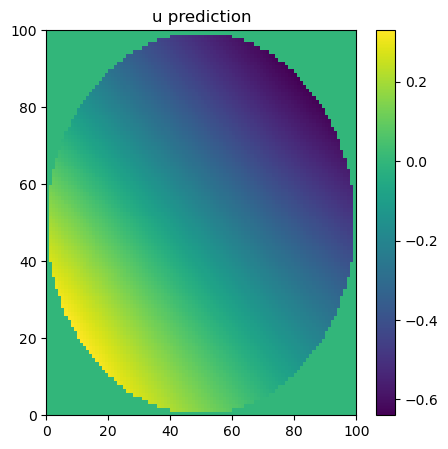

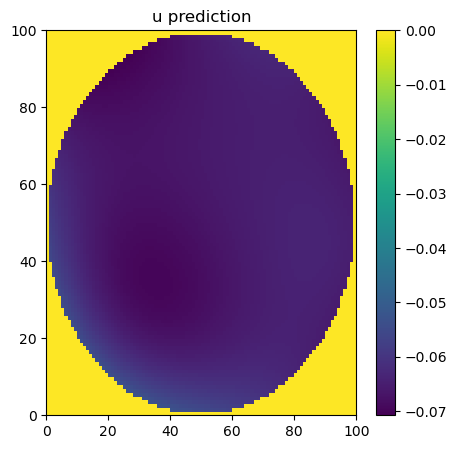

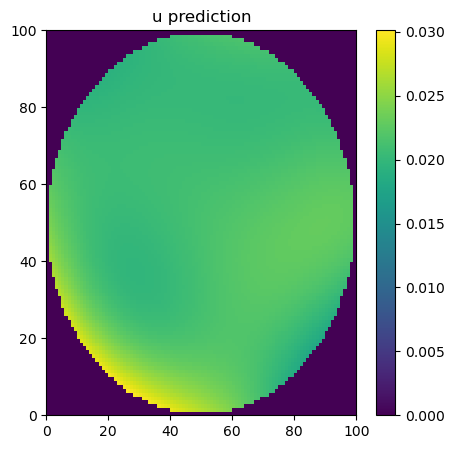

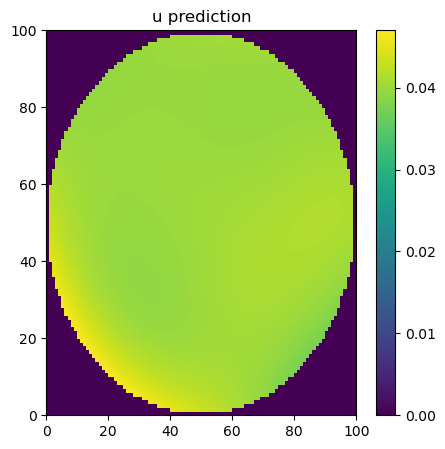

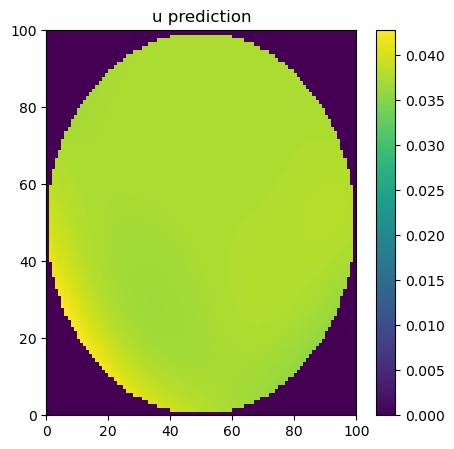

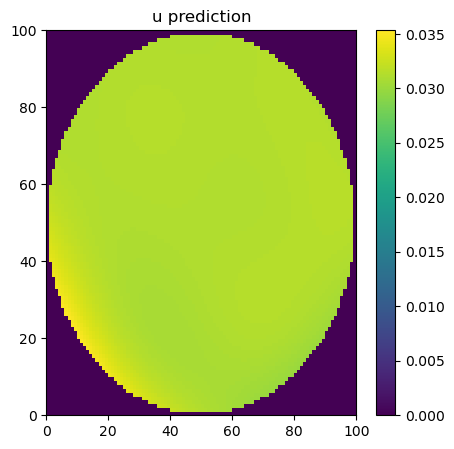

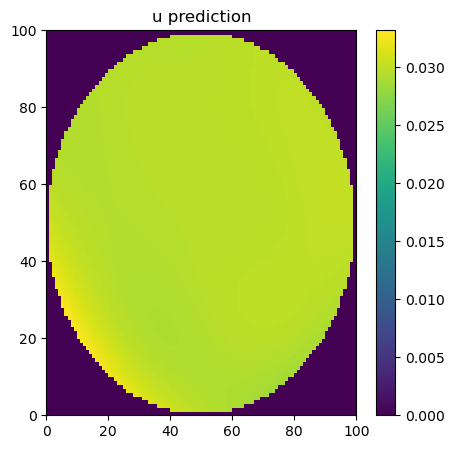

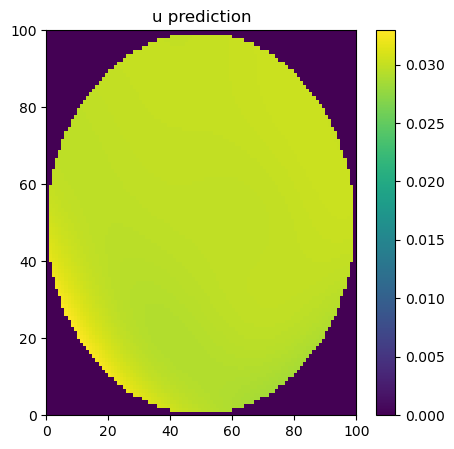

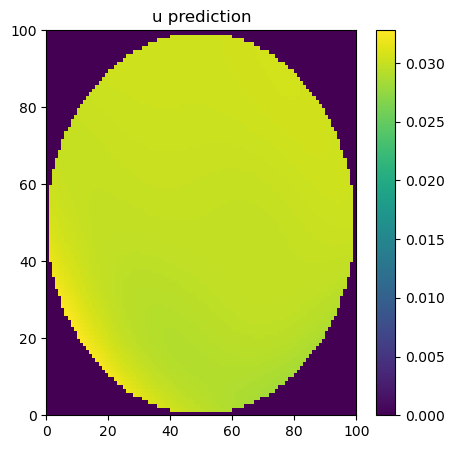

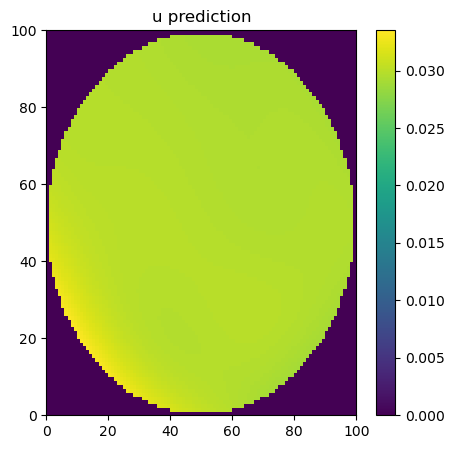

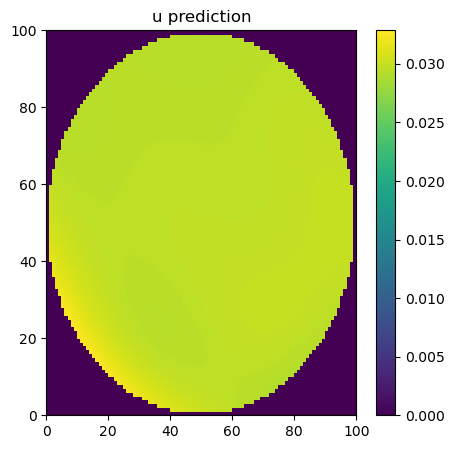

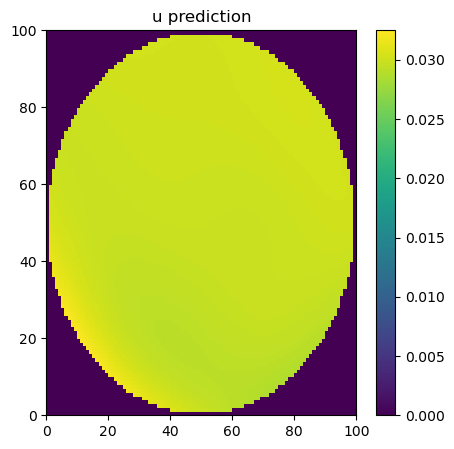

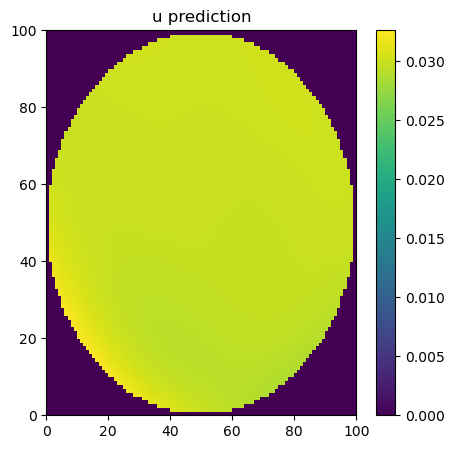

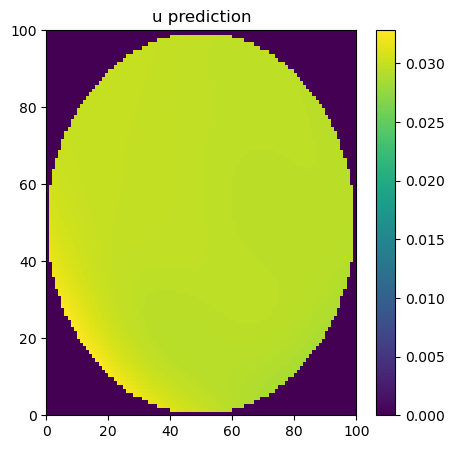

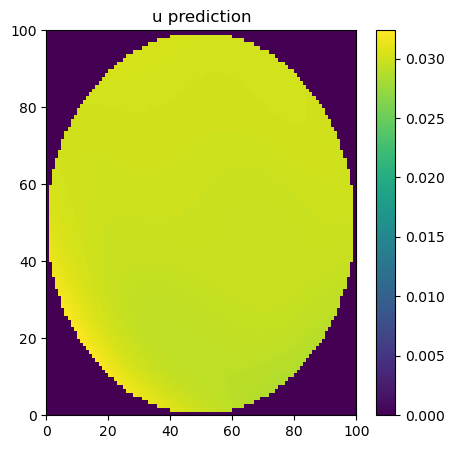

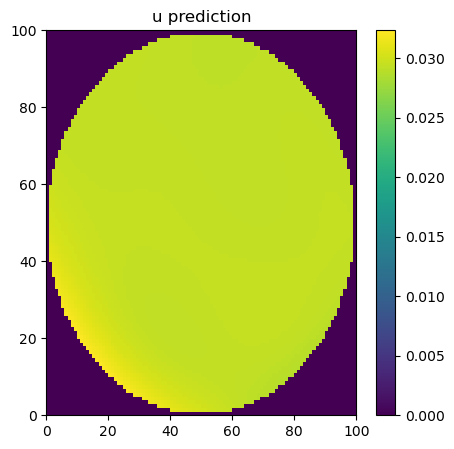

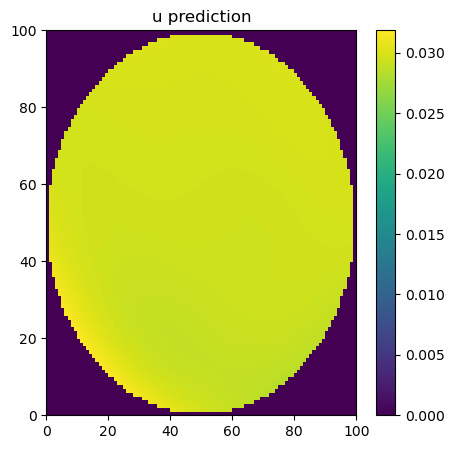

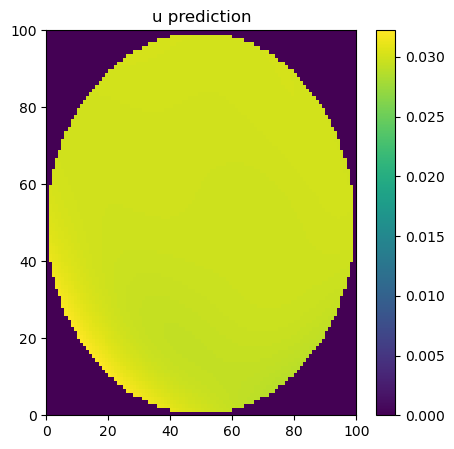

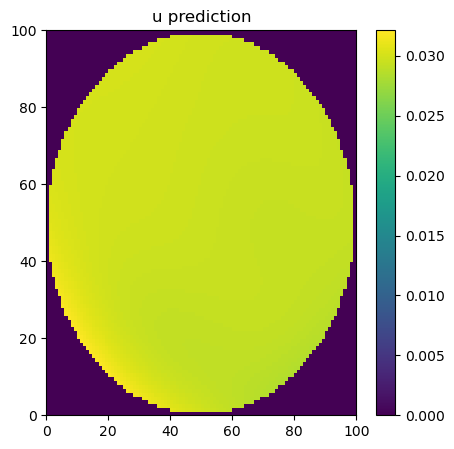

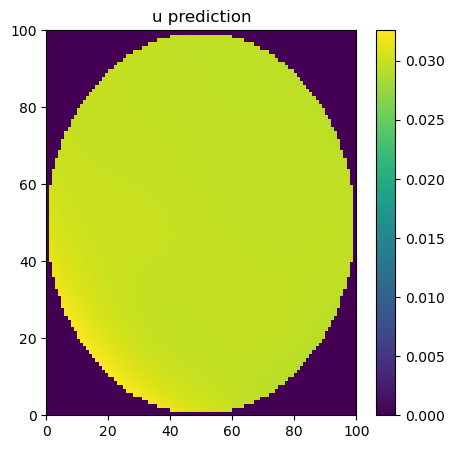

In [133]:
u_model = model(hidden_dims=[2,26,26,26,10,1]).to(device)
#s_model = model(hidden_dims=[2,64,64,64,1]).to(device)
optimizer = torch.optim.Adam([{'params': u_model.parameters()}], lr=1e-4)

loss_f = nn.MSELoss()
EPOCHS = 20000
loss_inf=0
for i in tqdm(range(EPOCHS)) :
    loss_l2, loss_inf, loss_bdry = train(u_model, optimizer, loss_f)

    if i % 100 == 0 :
        test_err = F.mse_loss(u_model(x_int),u_int).item()
        print("%s/%s | loss_l2: %06.6f |  loss_inf: %06.6f | loss_bdry: %06.6f | test_err: %06.6f" % \
              (i, EPOCHS, loss_l2, loss_inf, loss_bdry, test_err))
    if i % 1000 == 0 :
        plot(u_model)
